In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import time

In [1]:
def fk(angles, lengths):

    pos_list = [[0,0]]

    pos_x = angles[0].cos() * lengths[0]
    pos_y = angles[0].sin() * lengths[0]

    pos_list.append([pos_x.numpy(force=True), pos_y.numpy(force=True)])
    
    pos_x = pos_x + (angles[0] + angles[1]).cos() * lengths[1]
    pos_y = pos_y + (angles[0] + angles[1]).sin() * lengths[1]
    
    pos_list.append([pos_x.numpy(force=True), pos_y.numpy(force=True)])
    
    pos_x = pos_x + (angles[0] + angles[1] + angles[2]).cos() * lengths[2]
    pos_y = pos_y + (angles[0] + angles[1] + angles[2]).sin() * lengths[2]
    
    pos_list.append([pos_x.numpy(force=True), pos_y.numpy(force=True)])

    return pos_x, pos_y, pos_list

In [13]:

def ik(pos_target, lengths, angles_initial=torch.tensor([0.0, 0.0, 0.0]), plot=True, steps=1000):

    t_start = time.time()

    lr=0.001

    angles_curr = angles_initial.clone()
    optimizer = torch.optim.LBFGS([angles_curr], lr=lr, max_iter=steps)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    losses = []
    grads = []

    for step in range(steps):
        
        # L-BFGS
        def closure():
            
            angles_curr.requires_grad = True
            
            optimizer.zero_grad()
            
            pos_x, pos_y, pos_list = fk(angles_curr, lengths)

            dx = pos_x - pos_target[0]
            dy = pos_y - pos_target[1]

            loss = dx**2 + dy**2 + torch.abs(dx) + torch.abs(dy)
                
            loss.backward()

            return loss
        
        # keep angles close to zero
        # std = 0.0001
        # loss += torch.sum(angles_curr**2) * (1.0 / (std * np.sqrt(2.0 * np.pi))) * torch.exp(-0.5 * (loss / std)**2)

        # do step
        optimizer.step(closure)
        scheduler.step()

        losses.append(closure().numpy(force=True))
        grads.append(angles_curr.grad.abs().sum().numpy(force=True))
        
        # print(epoch, loss, angles_curr, loss)
        print(step, losses[step], scheduler.get_last_lr())

    t_end = time.time()
    duration = t_end - t_start

    print(f"duration: {duration*1000:.3f} ms")

    if(plot):
        
        matplotlib.rcParams['figure.figsize'] = [8,8]
        fig, axs = plt.subplots(nrows=2)

        ax = axs[0]
        ax.set_title("Loss")
        ax.plot(np.arange(len(losses)), losses, color="black")
        ax.set_yscale("log")
        ax.grid()
        
        ax = axs[1]
        ax.set_title("Gradient")
        ax.plot(np.arange(len(grads)), grads, color="blue")
        ax.set_yscale("log")
        ax.grid()

        plt.show()

    return angles_curr


0 0.038808607 [0.00099]
1 0.00041002713 [0.0009801]
2 0.00040901327 [0.000970299]
3 0.00040406306 [0.0009605960099999999]
4 0.00040304923 [0.0009509900498999999]
5 0.0003996497 [0.0009414801494009999]
6 0.0003989341 [0.0009320653479069899]
7 0.00039786063 [0.00092274469442792]
8 0.00039786048 [0.0009135172474836408]
9 0.00039368574 [0.0009043820750088043]
10 0.00039297013 [0.0008953382542587163]
11 0.00039213512 [0.0008863848717161291]
12 0.00038336834 [0.0008775210229989678]
13 0.00038235454 [0.0008687458127689781]
14 0.00037841834 [0.0008600583546412883]
15 0.0003763907 [0.0008514577710948754]
16 0.00037328954 [0.0008429431933839266]
17 0.00037245455 [0.0008345137614500873]
18 0.00037042695 [0.0008261686238355864]
19 0.0003673258 [0.0008179069375972306]
20 0.0003632703 [0.0008097278682212583]
21 0.00035551717 [0.0008016305895390457]
22 0.00035474182 [0.0007936142836436553]
23 0.0003539665 [0.0007856781408072188]
24 0.000351581 [0.0007778213593991466]
25 0.00034168104 [0.0007700431458

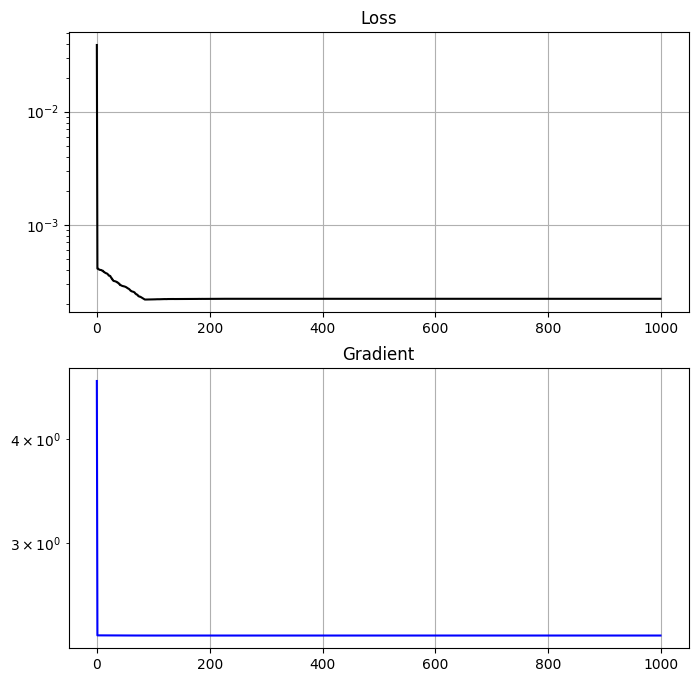

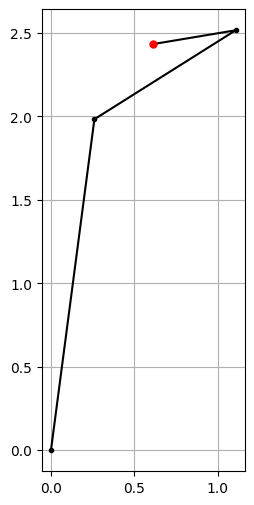

In [14]:
pos_target = torch.tensor([
    np.random.uniform(0.5, 2.5),
    np.random.uniform(0.5, 2.5),
])
lengths = torch.tensor([2.0, 1.0, 0.5], requires_grad=True)
angles_initial = torch.tensor([0.0, 0.0, 0.0])

angles_result = ik(pos_target, lengths, angles_initial)
pos_x, pos_y, pos_list = fk(angles_result, lengths)
pos_list = np.array(pos_list)

matplotlib.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()

ax.plot(pos_list[:,0], pos_list[:,1], color="black", ms=3, marker="o")
ax.plot(pos_target[0], pos_target[1], color="red", ms=5, marker="o")
ax.set_aspect("equal")
ax.grid()

plt.show()

duration: 192.055 ms
duration: 191.939 ms
duration: 206.566 ms
duration: 189.614 ms
duration: 193.660 ms
duration: 226.900 ms


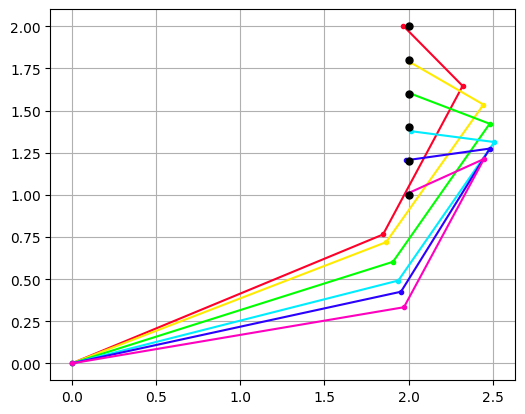

In [47]:
pos_target_list = [
    torch.tensor([2.0, 2.0]),
    torch.tensor([2.0, 1.8]),
    torch.tensor([2.0, 1.6]),
    torch.tensor([2.0, 1.4]),
    torch.tensor([2.0, 1.2]),
    torch.tensor([2.0, 1.0]),
]

lengths = torch.tensor([2.0, 1.0, 0.5], requires_grad=True)
angles_initial = torch.tensor([0.0, 0.0, 0.0])

matplotlib.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()
colormap = matplotlib.colormaps['gist_rainbow']
colors = colormap(np.linspace(0.0, 1.0, len(pos_target_list)))

for i, pos_target in enumerate(pos_target_list):
    
    angles_result = ik(pos_target, lengths, angles_initial, plot=False, steps=100)
    pos_x, pos_y, pos_list = fk(angles_result, lengths)
    pos_list = np.array(pos_list)
    
    angles_initial = angles_result.detach().clone()
    
    color = colors[i]

    ax.plot(pos_list[:,0], pos_list[:,1], color=color, ms=3, marker="o")
    ax.plot(pos_target[0], pos_target[1], color="black", ms=5, marker="o")

ax.set_aspect("equal")
ax.grid()

plt.show()


